In [ ]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 33.98 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Convolution2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
import ntpath
import random

In [ ]:
dir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(dir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [ ]:
def stripPath(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(stripPath)
data['left'] = data['left'].apply(stripPath)
data['right'] = data['right'].apply(stripPath)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


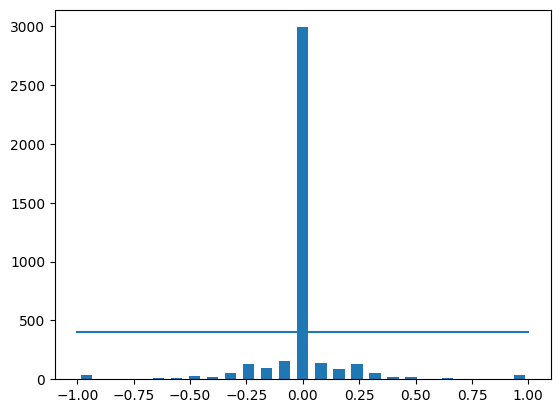

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list), 'images')
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data), 'images')

removed 2590 images
remaining 1463 images


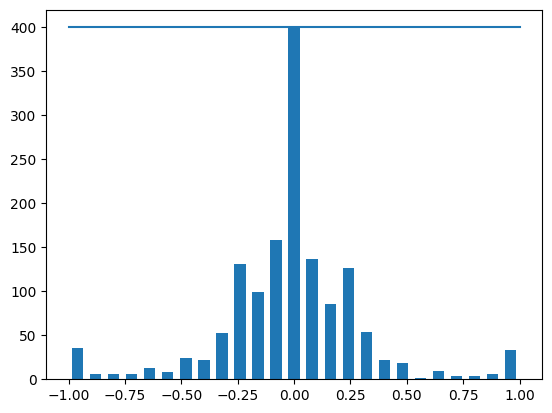

In [ ]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_steering_images(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))

    #left images
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.2)

    #right images
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.2)

  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path,steering

In [ ]:
image_path, steerings = load_steering_images(dir + '/IMG',data)

In [ ]:
image_path

array(['track/IMG/center_2018_07_16_17_11_43_860.jpg',
       'track/IMG/left_2018_07_16_17_11_43_860.jpg',
       'track/IMG/right_2018_07_16_17_11_43_860.jpg', ...,
       'track/IMG/center_2018_07_16_17_16_31_685.jpg',
       'track/IMG/left_2018_07_16_17_16_31_685.jpg',
       'track/IMG/right_2018_07_16_17_16_31_685.jpg'], dtype='<U44')

In [ ]:
steerings

array([ 0. ,  0.2, -0.2, ...,  0. ,  0.2, -0.2])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_path, steerings, test_size=0.2, random_state=6)

In [ ]:
def image_preprocessing(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

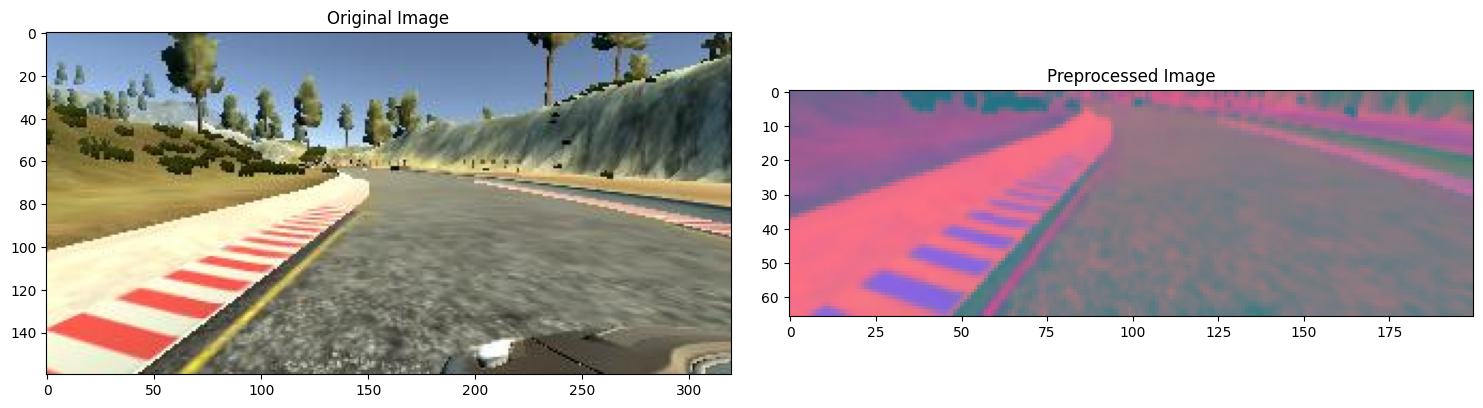

In [ ]:
image = image_path[100]
original_image = mpimg.imread(image)
preprocessed_image = image_preprocessing(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)  # get a random index

      im = mpimg.imread(image_paths[random_index])
      steering = steering_ang[random_index]

      im = image_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
x_train_generated, y_train_generated = next(batch_generator(X_train, y_train, 1, 1))
x_valid_generated, y_valid_generated = next(batch_generator(X_valid, y_valid, 1, 0))

In [ ]:
def self_driving_model():
  model = Sequential()
  model.add(Conv2D(24,( 5, 5), strides=(2, 2), activation='elu', input_shape=(66, 200, 3)))
  model.add(Conv2D(36,( 5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48,( 5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64,( 5, 5), activation='elu'))
  # model.add(Conv2D(64,( 3, 3), activation='elu'))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1))

  optimizer = keras.optimizers.Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model



In [ ]:
model = self_driving_model()
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_16 (Conv2D)          (None, 1, 18, 64)         76864     
                                                                 
 dropout_2 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 100)              

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=50,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,verbose=1,shuffle=1)

<ipython-input-39-3010864df9f4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/50
300/300 [==============================] - 288s 961ms/step - loss: 0.0130 - val_loss: 0.0263
Epoch 2/50
300/300 [==============================] - 274s 915ms/step - loss: 0.0119 - val_loss: 0.0255
Epoch 3/50
300/300 [==============================] - 287s 957ms/step - loss: 0.0107 - val_loss: 0.0247
Epoch 4/50
300/300 [==============================] - 291s 972ms/step - loss: 0.0100 - val_loss: 0.0269
Epoch 5/50
300/300 [==============================] - 269s 895ms/step - loss: 0.0092 - val_loss: 0.0265
Epoch 6/50
300/300 [==============================] - 299s 997ms/step - loss: 0.0091 - val_loss: 0.0286
Epoch 7/50
300/300 [==============================] - 270s 900ms/step - loss: 0.0079 - val_loss: 0.0259
Epoch 8/50
300/300 [==============================] - 269s 896ms/step - loss: 0.0077 - val_loss: 0.0281
Epoch 9/50
300/300 [==============================] - 270s 898ms/step - loss: 0.0071 - val_loss: 0.0255
Epoch 10/50
300/300 [==============================] - 269s 898m

Text(0.5, 0, 'epoch')

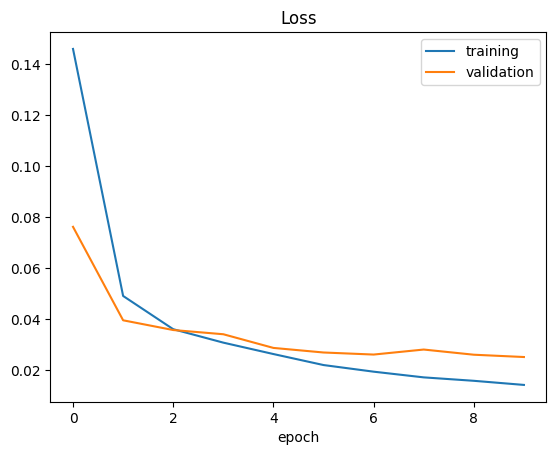

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>